Airline Revenue Management: an introduction
===================================
The example is from Andirs Moller, Werner Romisch, Klaus Weber, Airline Network Revenue Management by Multistage Stochastic Programming.

An airline company manages flights between three cities $A,B,C$. In the middle of the three cities, there is a hub serves as a transition point. The company wants to determine the seat protection level for all itineraries, fare classes to maximize the revenue over a horizon of 14 stages. Every stage corresponds to a departure date. Cancellation rate $\Gamma$ is deterministic. Demand is random. 

Notation
-----------
Itinerary $(i)$: AH, HA, BH, HB, CH, HC, AHB, BHA, AHC, CHA, BHC, CHB  
Fare class $(j)$: E1, E2, E3, E4, B1, B2 (Four economy classes, two business classes)  
Flight leg $(l)$: AH, HA, BH, HB, CH, HC  
Cabin $(k)$: Economy, Business  
 $f_{i,j}$: price of flight (assuming price doesn't change over time and 100 percent refund if cancellation)  
 $d_{i,j,t}$: demand  
 $b_{i,j,t}$: number of fulfilled booking  
 $B_{i,j,t}$: cumulative fulfilled booking  
 $c_{i,j,t}$: number of cancellation  
 $C_{i,j,t}$: cumulative cancellation  
 $\Gamma_{i}$: cancellation rate  
 $R_{k}$: capacity for each cabin in each flight leg
 

Formulation
----------------
\begin{align*}
\max~ &\sum_{t=1}^T\sum_{i}\sum_{j}[f_{i,j}^\top b_{i,j,t} - f_{i,j}^\top c_{i,j,t}]\\
\textrm{s.t.}~ &  \forall t = 1,\dots,T,\forall i,\forall j,\forall k,\forall l\\
&B_{i,j,t} = B_{i,j,t-1} + b_{i,j,t}, C_{i,j,t} = C_{i,j,t-1} + c_{i,j,t}\\
&c_{i,j,t} = \Gamma_{i,j} b_{i,j,t}\\
&A_{kl}(B_t - C_t)\leq R_{k}\\
&b_{i,j,t}\leq d_{i,j,t}\\
&B_{i,j,0} = 0, C_{i,j,0} = 0\\
&b_{i,j,t}\in\mathbb{Z^+},c_{i,j,t}\in\mathbb{Z^+}
\end{align*}
Where $A_{kl}$ is a 0-1 matrix that indicates whether a booking request for a particular itinerary and fare class fills up one unit of cabin capacity in a flight leg. For example, if a booking request is made for class B2 of itinerary AHB. Since this request fills up one unit of business cabin in both flight leg AH and flight leg HB, Entry (AHB,B2) in matrix $A_{B,AH}$ and $A_{B,HB}$ is one.

Data
------

In [1]:
import numpy, pandas
from scipy.stats import beta
import seaborn
seaborn.set_style('darkgrid')

In [2]:
I = ['AH','HA','BH','HB','CH','HC','AHB','BHA','AHC','CHA','BHC','CHB']
J = ['B1','B2','E1','E2','E3','E4']
L = ['AH','HA','BH','HB','CH','HC']
K = ['B','E']
Rate = {'AH':0.1,'HA':0.1,'BH':0.1,'HB':0.1,'CH':0.05,'HC':0.05,'AHB':0.05,'BHA':0.05,'AHC':0,'CHA':0,'BHC':0,'CHB':0}  
R = {'B':24, 'E':215}  

There are 14 departure dates thus the problem has 14 stages. We will generate 100 samples for each stage. A random seed is set.

In [3]:
day = [182,126,84,56,35,21,14,10,7,5,3,2,1,0] 
T = 14

Model the uncertain demand
--------------------------------------
To model the demand process, we need to take into account two things. One is the uncertain total number of cumulative booking requests, the other is the uncertain arrival pattern. The non-homogenous Poisson process is a perfect model to include both of them.  
The expected total number of cumulative booking requests over the booking horizon $G_{i,j}$ is assumed to be follow a Gamma distribution. Gamma distribution is chosen due to empirical evidence and analytical convenience that Gamma is the conjugate prior of the Poisson distribution.  
Arrival pattern of the booking requests $\beta_{i,j}(t)$ is assumed to follow Beta distribution to allow flexible shape.   
Arrival intensity function of booking requests is then given by $\lambda_{i,j}(t)=\beta_{i,j}(t) G_{i,j}$.  
Arrival intensity of booking request $d_{i,j}(t)$ over a booking interval $[t_n, t_m]$ is thus $G_{i,j} [F_{\beta_{i,j}}(t_m)-F_{\beta_{i,j}}(t_n)]$.  
In the end, demand process is modelled by number of booking requests subtracting cancellation. This is acheived by scaling $G_{i,j}$ with a cancelling rate. 

In [4]:
airFare = pandas.read_csv("data/airFare.csv", index_col = [0,1])

The first two columns give parameters of Gamma distribution; the next two columns give parameters of Beta distribution; the last column gives the prices.

In [5]:
airFare.head(n = 12)

k  theta   a    b  fare
i  j                              
AH B1   3.00    1.5  12  1.5   500
   B2   3.00    1.5   8  2.0   340
   E1  10.00    1.2   6  2.0   200
   E2  13.33    1.2   4  3.0   160
   E3  22.00    1.0   3  4.0   130
   E4  30.00    1.0   2  4.0   100
HA B1   3.00    1.5  12  1.5   500
   B2   3.00    1.5   8  2.0   340
   E1  10.00    1.2   6  2.0   200
   E2  13.33    1.2   4  3.0   160
   E3  22.00    1.0   3  4.0   130
   E4  30.00    1.0   2  4.0   100

In [6]:
def demand_sampler(random_state, size):
    demand = numpy.zeros([size,T,len(I)*len(J)])
    for i_idx,i in enumerate(I):
        for j_idx,j in enumerate(J):
            gamma_k,gamma_theta,beta_a,beta_b = airFare.loc[i,j][:4]
            G = random_state.gamma(gamma_k, gamma_theta, size=size) * (1-Rate[i])
            for t in range(1,T):
                B = (
                    beta.cdf(1-day[t]/day[0], beta_a, beta_b) 
                    - beta.cdf(1-day[t-1]/day[0], beta_a, beta_b)
                )
                demand[:,t,6*i_idx+j_idx] = random_state.poisson(G*B)
    return demand


In [7]:
airFare.head(10)

k  theta   a    b  fare
i  j                              
AH B1   3.00    1.5  12  1.5   500
   B2   3.00    1.5   8  2.0   340
   E1  10.00    1.2   6  2.0   200
   E2  13.33    1.2   4  3.0   160
   E3  22.00    1.0   3  4.0   130
   E4  30.00    1.0   2  4.0   100
HA B1   3.00    1.5  12  1.5   500
   B2   3.00    1.5   8  2.0   340
   E1  10.00    1.2   6  2.0   200
   E2  13.33    1.2   4  3.0   160

Solution
-----------

In [8]:
from msppy.msp import MSIP
from msppy.solver import SDDiP
import gurobipy
from msppy.evaluation import Evaluation, EvaluationTrue

Consider using Strengthened Benders' cuts to solve the MSIP. For illustration purpose, the Markov chain approximation below is very coarse and I only run SDDiP for 10 iterations. 

In [9]:
airline = MSIP(T, sense=-1)
airline.add_Markovian_uncertainty(demand_sampler)
for t in range(T):
    m = airline[t]
    # accumulated fulfilled booking requests
    B_now, B_past = m.addStateVars(I,J, vtype='I', name="B")
    # accumulated cancellation
    C_now, C_past = m.addStateVars(I,J, vtype='I', name="C")
    if t == 0:
        m.addConstrs(B_now[(i,j)] == 0 for i in I for j in J)
        m.addConstrs(C_now[(i,j)] == 0 for i in I for j in J)
    else:
        # new fulfilled booking requests
        b = m.addVars(I,J, obj=numpy.array(airFare['fare']), name="b", vtype='I')
        c = m.addVars(I,J, obj=-numpy.array(airFare['fare']), name="c", vtype='I')
        # accumulated fulfilled booking requests updated
        m.addConstrs(B_now[(i,j)] == B_past[(i,j)] + b[(i,j)] for i in I for j in J)
        m.addConstrs(C_now[(i,j)] == C_past[(i,j)] + c[(i,j)] for i in I for j in J)
        # number of cancellation is depending on the cancellation rate
        m.addConstrs(C_now[(i,j)] <= Rate[i] * B_now[(i,j)] + 0.5 for i in I for j in J)
        m.addConstrs(C_now[(i,j)] >= Rate[i] * B_now[(i,j)] - 0.5 for i in I for j in J)
        # capacity constraint
        m.addConstrs(
            gurobipy.quicksum(
                B_now[(i,j)] - C_now[(i,j)] for i in I for j in J
                if l in i and j.startswith(k)
            )
            <= R[k] for k in K for l in L
        )
        m.addConstrs(
            (b[(i,j)] <= 0 for i in I for j in J),
            uncertainty_dependent=[
                6*i+j for i in range(len(I)) for j in range(len(J))
            ]
        )
airline.discretize(
    method='SA',
    n_Markov_states=10,
    n_sample_paths=10*1000,
    int_flag=1,
)
airline_sddp = SDDiP(airline)
airline_sddp.solve(cuts=['SB'], max_iterations=30, logToConsole=0)
result = Evaluation(airline)
result.run(n_simulations=100)
resultTrue = EvaluationTrue(airline)
resultTrue.run(n_simulations=100)

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


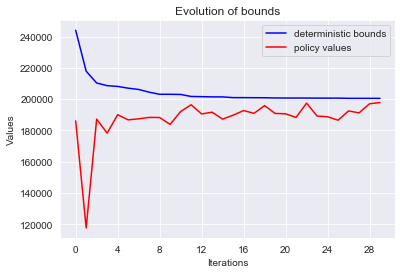

In [10]:
airline_sddp.plot_bounds();